# **Deep Learning - Image Classification** 
## **Group members:**

##### Yuval Berland
##### Sagi Huly 
##### Narkis Raam 
##### Dana Shidlovsky





### **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten , Input , Conv2D, UpSampling2D
from keras.layers.regularization.dropout import Dropout
from keras.layers.pooling.max_pooling2d import MaxPooling2D
from tensorflow.keras.regularizers import l2
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.normalization import batch_normalization
from keras.layers.pooling.average_pooling2d import AveragePooling2D
from sklearn.metrics import accuracy_score

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import layers

import os
import shutil
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Load the data**

In [ ]:
x_train = np.load('/content/drive/My Drive/Colab Notebooks/data/X_train.npy')
y_train = np.load('/content/drive/My Drive/Colab Notebooks/data/Y_train.npy')
x_test = np.load('/content/drive/My Drive/Colab Notebooks/data/X_test.npy')
y_test = np.load('/content/drive/My Drive/Colab Notebooks/data/Y_test.npy')

In [ ]:
x_train = x_train.astype(int)
y_train = y_train.astype(int)
x_test = x_test.astype(int)
y_test = y_test.astype(int)
print('Shape of x_train is:', x_train.shape)
print('Shape of y_train is:', y_train.shape)
print('Shape of x_test is:', x_test.shape)
print('Shape of y_test is:', y_test.shape)

Shape of x_train is: (3200, 180, 180, 3)
Shape of y_train is: (3200,)
Shape of x_test is: (800, 180, 180, 3)
Shape of y_test is: (800,)


###**First look at the data**

<Figure size 432x288 with 0 Axes>

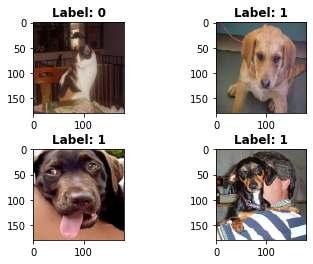

In [ ]:
def plot_random_samples(x, y):
  plt.figure()
  f, axarr = plt.subplots(2, 2, gridspec_kw={'hspace':0.4}) 
  rands = np.random.randint(x.shape[0], size=4)
  axarr[0, 0].imshow(x[rands[0], :, :])
  axarr[0, 0].set_title('Label: ' + str(y[rands[0]]), fontweight='bold')
  axarr[1, 0].imshow(x[rands[1], :, :])
  axarr[1, 0].set_title('Label: ' + str(y[rands[1]]), fontweight='bold')
  axarr[0, 1].imshow(x[rands[2], :, :])
  axarr[0, 1].set_title('Label: ' + str(y[rands[2]]), fontweight='bold')
  axarr[1, 1].imshow(x[rands[3], :, :])
  axarr[1, 1].set_title('Label: ' + str(y[rands[3]]), fontweight='bold')
  plt.show()

plot_random_samples(x_train, y_train)

### **Split the trainging data**

In [ ]:
x_train.shape

(3200, 180, 180, 3)

In [ ]:
# Normalize data by dividing the data with the maximal value as a float to map it to a range of [0, 1].
x_train = x_train/255.0
x_test = x_test/255.0

#Spilt training data into training vs validation:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=1/4)
x_val.shape, x_test.shape

((800, 180, 180, 3), (800, 180, 180, 3))

### **General functions and definitions**

In [ ]:
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor="val_loss",factor=0.7,patience=4)

In [ ]:
# early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=10**-7, patience=10, verbose=1,mode='min', restore_best_weights=True)

### **reset GPU memory**

In [ ]:
# reset gpu memory
!pip install numba
from numba import cuda 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Training Pipline**

In [ ]:
# train pipeline
from keras.callbacks import ModelCheckpoint
def train_model_pipeline(model, epochs, batch_size, custom_callbacks):
  callbacks = []
  # check if need to add more callbacks
  if custom_callbacks is not None:
    callbacks.extend(custom_callbacks)
  # train model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

## **Basic Model**

In [ ]:
basic_model = Sequential(name='basic_model')

In [ ]:
basic_model.add(Input(shape =(180, 180, 3)))
basic_model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Conv2D(64, kernel_size=(3,3),kernel_regularizer=l2(0.001), activation="relu"))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Dropout(0.25))
basic_model.add(Conv2D(128, kernel_size=(3,3),kernel_regularizer=l2(0.001), activation="relu"))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Conv2D(256, kernel_size=(3,3), kernel_regularizer=l2(0.001), activation="relu"))
basic_model.add(MaxPooling2D(pool_size=(2,2)))
basic_model.add(Dropout(0.25))
basic_model.add(Flatten())
basic_model.add(Dense(1, activation='sigmoid'))

In [ ]:
basic_model.summary()

Model: "basic_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 43, 43, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       

In [ ]:
basic_model_epochs = 20
basic_model_batch_size = 64

In [ ]:
train_model_pipeline(basic_model, basic_model_epochs, basic_model_batch_size, [reduce_lr, early_stop])

Epoch 1/20
38/38 [==============================] - 21s 151ms/step - loss: 0.9010 - accuracy: 0.5192 - val_loss: 0.8131 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 2/20
38/38 [==============================] - 3s 90ms/step - loss: 0.7699 - accuracy: 0.5508 - val_loss: 0.7342 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 3/20
38/38 [==============================] - 4s 95ms/step - loss: 0.7123 - accuracy: 0.5908 - val_loss: 0.6980 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 4/20
38/38 [==============================] - 3s 90ms/step - loss: 0.6900 - accuracy: 0.5925 - val_loss: 0.6885 - val_accuracy: 0.5962 - lr: 0.0010
Epoch 5/20
38/38 [==============================] - 3s 90ms/step - loss: 0.6715 - accuracy: 0.6196 - val_loss: 0.6687 - val_accuracy: 0.6388 - lr: 0.0010
Epoch 6/20
38/38 [==============================] - 3s 90ms/step - loss: 0.6496 - accuracy: 0.6371 - val_loss: 0.6413 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 7/20
38/38 [==============================] - 3s 90ms/step - loss: 0

The train accuracy score

In [ ]:
y__train_pred = basic_model.predict(x_train)
y_pred_train_labels = y__train_pred.round()
accuracy_score(y_train, y_pred_train_labels)

75/75 [==============================] - 2s 20ms/step


0.8045833333333333

The test accuracy score


In [ ]:
y_pred = basic_model.predict(x_test)

25/25 [==============================] - 0s 16ms/step


In [ ]:
y_pred_labels = y_pred.round()
y_true_labels = y_test.round()

In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))

Accuracy:  0.7775


In [ ]:
len(basic_model.layers)

12

<Figure size 432x288 with 0 Axes>

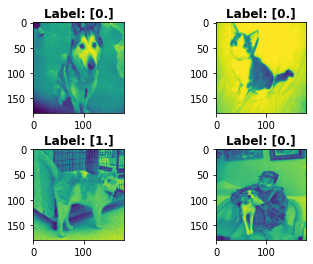

In [ ]:
plot_random_samples(x_test[:, :, :, 0], y_pred_labels)

### **Second model: our own CNN**

In [ ]:
# model initialization
CustomModel = Sequential(name='CustomModel')
# build model
CustomModel.add(Input(shape =(180, 180, 3)))

In [ ]:
CustomModel.add(Conv2D(64, kernel_size=(3,3), strides=2, activation="relu"))
CustomModel.add(MaxPooling2D(pool_size=(2,2)))
# BatchNormalization()
CustomModel.add(Dropout(0.25))


CustomModel.add(Conv2D(128, kernel_size=(3,3), strides=2, activation="relu"))
CustomModel.add(MaxPooling2D(pool_size=(2,2)))
BatchNormalization()
CustomModel.add(Dropout(0.3))


CustomModel.add(Conv2D(256, kernel_size=(3,3), activation="relu"))
CustomModel.add(AveragePooling2D(pool_size=(2,2)))
BatchNormalization()
CustomModel.add(Dropout(0.3))

CustomModel.add(Flatten())

CustomModel.add(Dense(256, activation='relu'))
CustomModel.add(Dropout(0.50))

CustomModel.add(Dense(1, activation='sigmoid'))

In [ ]:
CustomModel.summary()

Model: "CustomModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 89, 89, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 44, 44, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 44, 44, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 128)       

In [ ]:
CustomModelEpoches = 25
CustomModelBatchSize= 16

In [ ]:
train_model_pipeline(CustomModel, CustomModelEpoches, CustomModelBatchSize, [reduce_lr, early_stop])

Epoch 1/25
150/150 [==============================] - 3s 14ms/step - loss: 0.6964 - accuracy: 0.5175 - val_loss: 0.6922 - val_accuracy: 0.4837 - lr: 0.0010
Epoch 2/25
150/150 [==============================] - 2s 11ms/step - loss: 0.6919 - accuracy: 0.5204 - val_loss: 0.6878 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/25
150/150 [==============================] - 2s 11ms/step - loss: 0.6926 - accuracy: 0.5429 - val_loss: 0.6897 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 4/25
150/150 [==============================] - 2s 11ms/step - loss: 0.6856 - accuracy: 0.5600 - val_loss: 0.6907 - val_accuracy: 0.5088 - lr: 0.0010
Epoch 5/25
150/150 [==============================] - 2s 11ms/step - loss: 0.6846 - accuracy: 0.5663 - val_loss: 0.6763 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 6/25
150/150 [==============================] - 2s 11ms/step - loss: 0.6740 - accuracy: 0.5883 - val_loss: 0.6406 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 7/25
150/150 [==============================] - 2s 11ms/st

In [ ]:
len(CustomModel.layers)

13

The train accuracy score

In [ ]:
y__train_pred = CustomModel.predict(x_train)
y_pred_train_labels = y__train_pred.round()
accuracy_score(y_train, y_pred_train_labels)

75/75 [==============================] - 1s 11ms/step


0.9866666666666667

The test accuracy score

In [ ]:
y_pred = CustomModel.predict(x_test)
y_pred_labels = y_pred.round()
y_true_labels = y_test.round()

25/25 [==============================] - 0s 12ms/step


In [ ]:
print('Accuracy: ', accuracy_score(y_true_labels, y_pred_labels))

Accuracy:  0.80875


<Figure size 432x288 with 0 Axes>

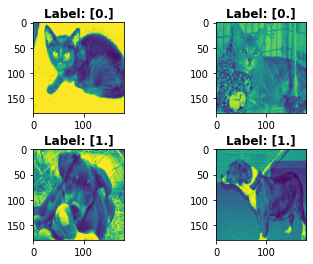

In [ ]:
plot_random_samples(x_test[:, :, :, 0], y_pred_labels)

### **Third model: load a pre-trained model from Keras applications**

In [ ]:
img_size = (180, 180)
inputs = tf.keras.Input(shape=img_size + (3,))
resnet = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_tensor=inputs)
resnet.trainable = False

In [ ]:
x = tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation="relu")(resnet.output)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Flatten()(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
resnet_model = tf.keras.Model(resnet.inputs, output)
resnet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 92, 92, 64)   0           ['conv1_conv[0][0]']       

In [ ]:
resnet_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Train the model, doing validation at the end of each epoch.
epochs = 20
resnet_model.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), batch_size=16)

Epoch 1/20
150/150 [==============================] - 13s 68ms/step - loss: 1.9955 - accuracy: 0.9442 - val_loss: 1.0221 - val_accuracy: 0.9600
Epoch 2/20
150/150 [==============================] - 10s 65ms/step - loss: 0.8202 - accuracy: 0.9704 - val_loss: 1.8471 - val_accuracy: 0.9500
Epoch 3/20
150/150 [==============================] - 9s 60ms/step - loss: 0.4155 - accuracy: 0.9837 - val_loss: 1.0156 - val_accuracy: 0.9700
Epoch 4/20
150/150 [==============================] - 10s 66ms/step - loss: 0.4881 - accuracy: 0.9821 - val_loss: 1.7277 - val_accuracy: 0.9600
Epoch 5/20
150/150 [==============================] - 9s 60ms/step - loss: 0.3168 - accuracy: 0.9912 - val_loss: 1.2899 - val_accuracy: 0.9675
Epoch 6/20
150/150 [==============================] - 10s 64ms/step - loss: 0.2654 - accuracy: 0.9896 - val_loss: 1.7214 - val_accuracy: 0.9613
Epoch 7/20
150/150 [==============================] - 9s 58ms/step - loss: 0.2685 - accuracy: 0.9900 - val_loss: 1.1970 - val_accuracy: 0.

The train accuracy score

In [ ]:
y__train_pred = resnet_model.predict(x_train)
y_pred_train_labels = y__train_pred.round()
accuracy_score(y_train, y_pred_train_labels)

75/75 [==============================] - 6s 67ms/step


0.9991666666666666

The test accuracy score

In [ ]:
y_pred = resnet_model.predict(x_test)

25/25 [==============================] - 2s 66ms/step


In [ ]:
y_pred_labels = y_pred.round()

In [ ]:
print('Accuracy: ', accuracy_score(y_test, y_pred_labels))

Accuracy:  0.97375


In [ ]:
len(resnet_model.layers)

195

<Figure size 432x288 with 0 Axes>

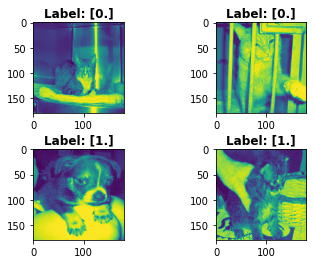

In [ ]:
plot_random_samples(x_test[:, :, :, 0], y_pred_labels)

## Summary


In [ ]:
import pandas as pd

results = {'model': ['Basic CNN', 'Our CNN', 'Resnet model'],
           'Test score (Accuracy)': ['0.7775', '0.80875', '0.97375'],
           'Train score (Accuracy)': ['0.8045', '0.9866', '0.9991'],
           'Number of trainable parameters': ['409,153', '1,419,905', '9,439,745'],
           'Number of layers': [len(basic_model.layers), len(CustomModel.layers), len(resnet_model.layers)],
           'Regularization methods': ['[MaxPooling2D, Dropout]', '[MaxPooling2D,AveragePooling2D, BatchNormalization, Dropout]', '[MaxPooling2D, Dropout]'],
           'Number of epochs': ['20', '25', '20'],
           'Loss function': ['binary_crossentropy', 'binary_crossentropy', 'binary_crossentropy'],
           'Optimizer': ['adam', 'adam', 'adam']
           }

df = pd.DataFrame(results)
df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer
0,Basic CNN,0.7775,0.8045,"409,153",12,"[MaxPooling2D, Dropout]",20,binary_crossentropy,adam
1,Our CNN,0.80875,0.9866,"1,419,905",13,"[MaxPooling2D,AveragePooling2D, BatchNormaliza...",25,binary_crossentropy,adam
2,Resnet model,0.97375,0.9991,"9,439,745",195,"[MaxPooling2D, Dropout]",20,binary_crossentropy,adam


In [ ]:
import os
from google.colab import files
df.to_csv(os.path.join(os.getcwd(), 'exercise2.csv'))
files.download('exercise2.csv')